# What makes an asteroid hazardous?

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotnine as p9
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score, accuracy_score
from sklearn.linear_model import RidgeCV
from cycler import cycler
from imblearn.over_sampling import SMOTE
method = SMOTE(k_neighbors = 3)
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("nasa.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Neo Reference ID              4687 non-null   int64  
 1   Name                          4687 non-null   int64  
 2   Absolute Magnitude            4687 non-null   float64
 3   Est Dia in KM(min)            4687 non-null   float64
 4   Est Dia in KM(max)            4687 non-null   float64
 5   Est Dia in M(min)             4687 non-null   float64
 6   Est Dia in M(max)             4687 non-null   float64
 7   Est Dia in Miles(min)         4687 non-null   float64
 8   Est Dia in Miles(max)         4687 non-null   float64
 9   Est Dia in Feet(min)          4687 non-null   float64
 10  Est Dia in Feet(max)          4687 non-null   float64
 11  Close Approach Date           4687 non-null   object 
 12  Epoch Date Close Approach     4687 non-null   int64  
 13  Rel

#### Hazardous:

In [3]:
#`hazardous` with value True: 
true =data[data['Hazardous']==True]
##`hazardous` with value False: 
false =data[data['Hazardous']==False]
print("# of Hazardous(Value = True):", true.shape[0])
print("# of Hazardous(Value = False):", false.shape[0])

#A column of the numerical bool values of `hazardous`:
data['hazar_bool'] = data['Hazardous'].apply(lambda x: 1 if x == True else 0) 

# of Hazardous(Value = True): 755
# of Hazardous(Value = False): 3932


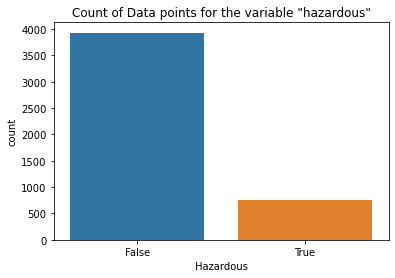

In [4]:
#Use histogram to show how the dataset is imbalanced
sns.countplot(data = data, x = 'Hazardous')
plt.title('Count of Data points for the variable "hazardous"')
plt.show()

In [5]:
#A copy of the dataframe:
new = data.copy()

#### Units of Measurement:


Some variables here are the measurement of the same quantity in different units. For easier and accurate interpretibility, a consistent system of measurement might sometimes be necessary. Therefore, SI units are chosen here. The measure of distance is 'm' and the measure of the time is 's'. 


In [6]:
#Change to SI units:
#-------------------
new['Relative Velocity m per sec'] = (new['Relative Velocity km per hr'] * 1000)/3600
new ['Miss Dist.(meters)'] = new['Miss Dist.(kilometers)'] * 1000

#### Variables that can be dropped:

Some variables like `Orbiting Body`, `Equinox` have only one unique value so adding them would not generate new information. Therefore, these variables can be dropped. 

Below are some variables that can be dropped: 
- `Orbiting Body`: Only one unique value 'Earth'
- `Hazardous`: `hazar_bool` is used instead. 
- `Equinox`: Only one unique value 'J2000'
- `Name`, `Neo Reference ID`: These variables can be dropped as they are the names of the variables. 
- As per the given project instructions, the system of measurement are changed to MKS system. So the variables `Est Dia in KM(min)`,`Est Dia in KM(max)`,`Relative Velocity km per hr`, `Miss Dist.(kilometers)`, `Est Dia in Miles(min)`,`Est Dia in Miles(max)`,`Est Dia in Feet(max)`,`Est Dia in Feet(min)`,`Miss Dist.(Astronomical)`,`Miss Dist.(lunar)`, `Miss Dist.(miles)`, `Relative Velocity km per sec`,`Miles per hour`are dropped. 



In [7]:
#Dropping values: 
new = new.drop(['Name', 'Neo Reference ID','Est Dia in KM(min)','Est Dia in KM(max)','Relative Velocity km per hr', 'Miss Dist.(kilometers)', 'Est Dia in Miles(min)','Est Dia in Miles(max)','Est Dia in Feet(max)','Est Dia in Feet(min)','Miss Dist.(Astronomical)',
        'Miss Dist.(lunar)', 'Miss Dist.(miles)', 'Relative Velocity km per sec','Miles per hour', 'Equinox', 'Hazardous', 'Orbiting Body'] , axis = 1)
new.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Absolute Magnitude           4687 non-null   float64
 1   Est Dia in M(min)            4687 non-null   float64
 2   Est Dia in M(max)            4687 non-null   float64
 3   Close Approach Date          4687 non-null   object 
 4   Epoch Date Close Approach    4687 non-null   int64  
 5   Orbit ID                     4687 non-null   int64  
 6   Orbit Determination Date     4687 non-null   object 
 7   Orbit Uncertainity           4687 non-null   int64  
 8   Minimum Orbit Intersection   4687 non-null   float64
 9   Jupiter Tisserand Invariant  4687 non-null   float64
 10  Epoch Osculation             4687 non-null   float64
 11  Eccentricity                 4687 non-null   float64
 12  Semi Major Axis              4687 non-null   float64
 13  Inclination       

### Distribution of the variables(visualization):


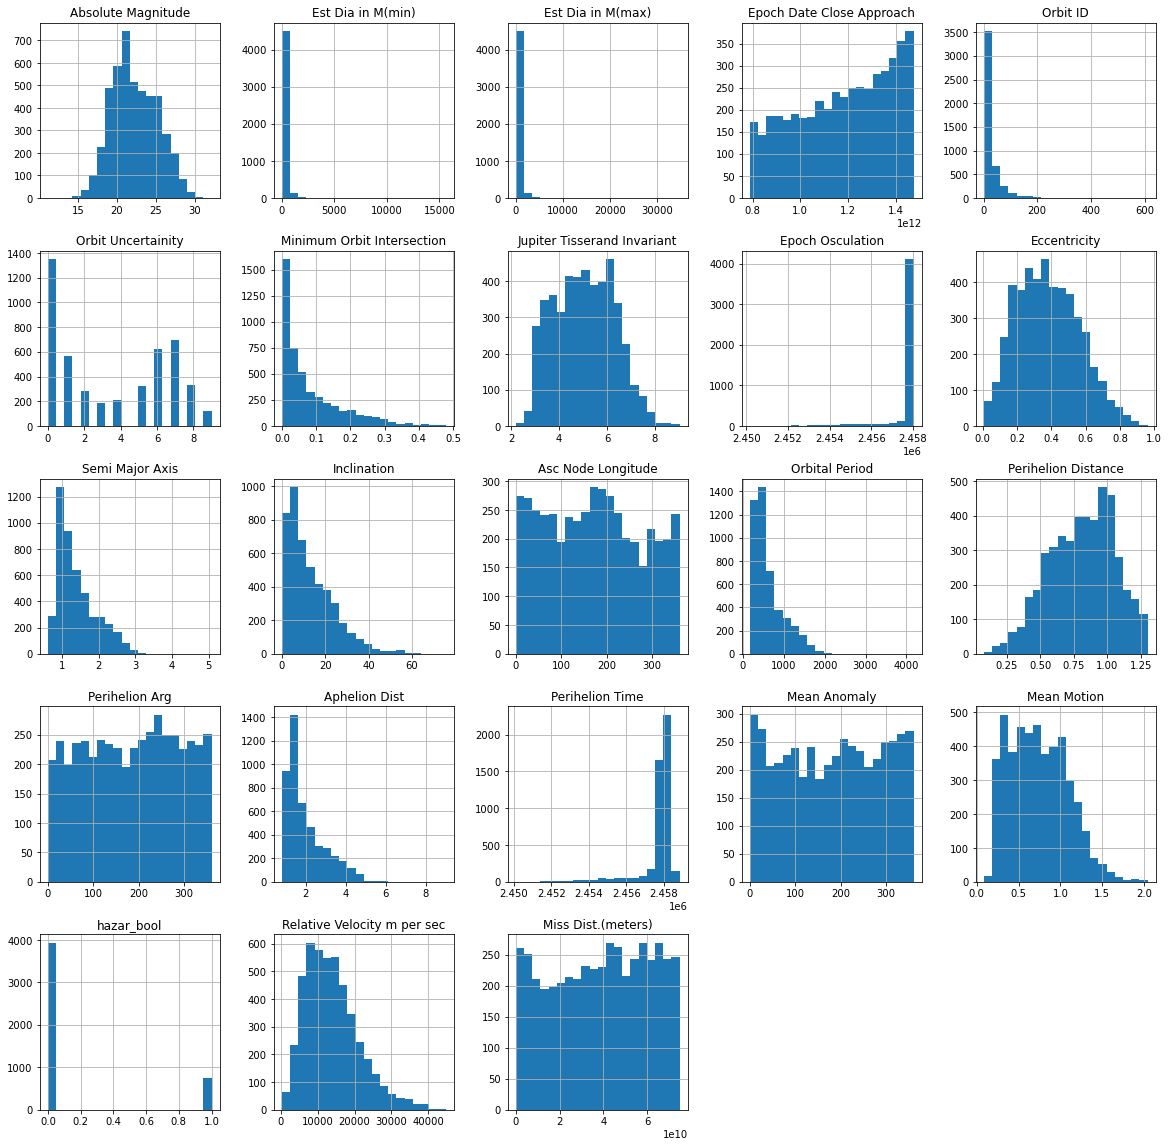

In [8]:
new.hist(bins=20, figsize=(20,20));

Not all the variables are Normal. If applying models with normality assumptions, the variables need to be transformed. 

### Collinearity:


IS IT ALWAYS NECESSARY TO REMOVE THEM?
WHY REMOVE/ NOT REMOVE?

Some ways to detect:

-- Correlation matrix best

-- since high multicollinearity the covariance matrix tolerance with be high because of condition number. Note: Not always the high covariance values indicate multicollinearity. 

-- When applying ols models,  the F-value will be high (f-value indicates the analysis of variance value indicating that variance are indeed different.) However the t-values(test for means) values for each predictor will be statistically insignificant. The interpretation is not to drop variables in this case, but since the OLS model is assumed to be additive(design matrix expected full column rank) the interpretation will no longer be that the beta value explains the change in the mean response. 




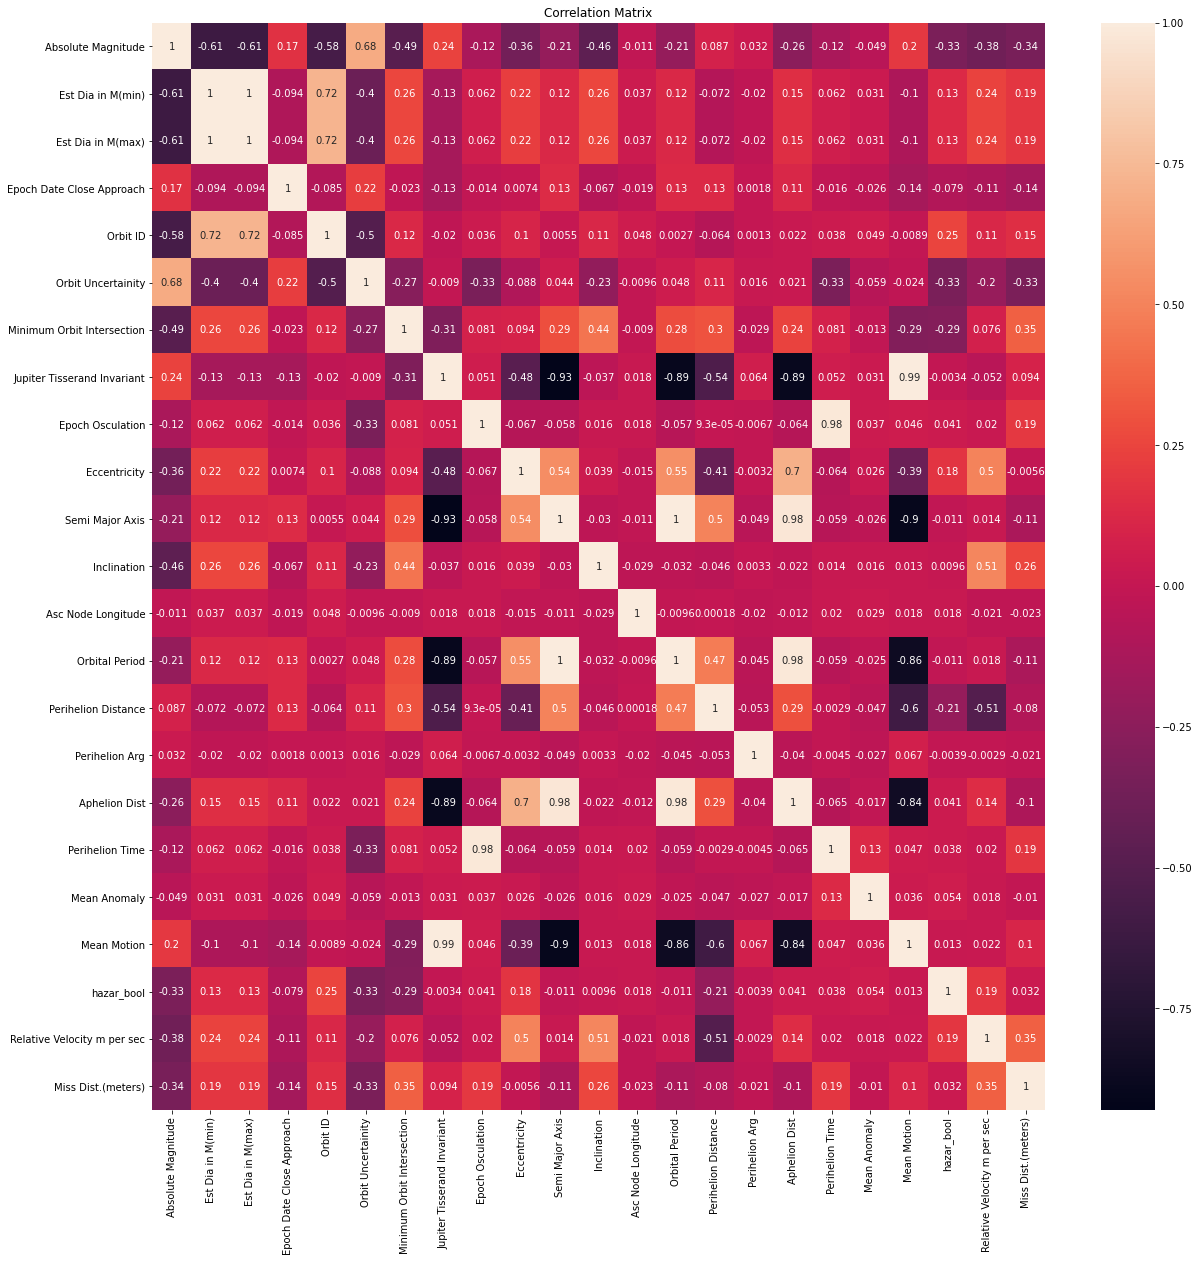

In [9]:
## Heatmap of Correlations:
plt.figure(figsize = (20,20))
sns.heatmap(new.corr(),annot = True)
plt.title("Correlation Matrix")
plt.savefig("corrmat1.png")

Highly correlated variables: 

1. `Perihelion Time` and `Epoch Osculation`
2.  `Apehelion Dist` and `Semi Major Axis`, `Orbital Period`, `Apehelion Dist`, `Mean Motion`, `Jupiter Tisserand Invariant`, `Perihelion Distance`
3. `Absolute Magnitude`, `Orbit ID`, `Orbit Uncertainty`, `Est Dia in M(min)`, `Est Dia in M(min)`

#### More ways to check and drop collinear variables and select only a relevant feature:

- Variance Inflation Factor (VIF):


- Shrinkage Method - Ridge Regression: This method is robust to multicollinearity.  

## VIF: 


In [10]:
### Variance Inflation Factor:

def vif_cal(correlated_features):
    """
    - Input is a list of variable names that are correalted
    - Returns VIF values of the variables that have been given as input
    """
    
    X = add_constant(new[correlated_features])
    df = pd.DataFrame([variance_inflation_factor(X.values, i) 
    for i in range(X.shape[1])], 
        index=X.columns).reset_index()
    df.columns = ['Variable', 'VIF']
    newdf = df[df['Variable'].isin(correlated_features)].sort_values('VIF', ascending=False)
    return newdf
    
##Source: https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python?msclkid=ac36ae14c40c11ecaa4ee883db65cb16

#### Drop the variable with largest VIF and then check again until VIF < 10: 


In [11]:
#features = ['Aphelion Dist', 'Semi Major Axis', 'Orbital Period', 'Mean Motion', 'Jupiter Tisserand Invariant', 'Absolute Magnitude', 'Orbit ID', 'Orbit Uncertainity', 'Perihelion Time' ,'Epoch Osculation', 'Est Dia in M(max)', 'Est Dia in M(min)']
column = ['Absolute Magnitude', 'Est Dia in M(min)', 'Est Dia in M(max)',\
       'Orbit ID','Orbit Uncertainity',\
       'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant',\
       'Epoch Osculation', 'Eccentricity', 'Semi Major Axis', 'Inclination',\
       'Asc Node Longitude', 'Orbital Period', 'Perihelion Distance',\
       'Perihelion Arg', 'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly',\
       'Mean Motion', 'hazar_bool', 'Relative Velocity m per sec',\
       'Miss Dist.(meters)']
features = column
vif = vif_cal(features)
vif


,Variable,VIF
10,Semi Major Axis,inf
3,Est Dia in M(max),inf
16,Aphelion Dist,inf
2,Est Dia in M(min),inf
14,Perihelion Distance,5.906360e+12
7,Jupiter Tisserand Invariant,1.282576e+03
13,Orbital Period,1.039371e+03
19,Mean Motion,7.964119e+02
17,Perihelion Time,2.769625e+01
8,Epoch Osculation,2.751654e+01


In [12]:
list_drop = []

 We drop this variable with the largest VIF and check the VIF again. 
<br>WE REPEAT THIS PROCESS UNTIL ALL VIF VALUES ARE <10:


In [13]:
remove = list(vif['Variable'])[0]
list_drop.append(remove)
features.remove(remove)
vif = vif_cal(features)
vif


,Variable,VIF
3,Est Dia in M(max),inf
2,Est Dia in M(min),inf
15,Aphelion Dist,1553.740858
7,Jupiter Tisserand Invariant,1282.576480
12,Orbital Period,1039.371292
18,Mean Motion,796.411892
13,Perihelion Distance,59.539317
16,Perihelion Time,27.696250
8,Epoch Osculation,27.516542
9,Eccentricity,19.039145


In [14]:
remove = list(vif['Variable'])[0]
list_drop.append(remove)
features.remove(remove)
vif = vif_cal(features)
vif

,Variable,VIF
14,Aphelion Dist,1553.740858
6,Jupiter Tisserand Invariant,1282.576480
11,Orbital Period,1039.371293
17,Mean Motion,796.411892
12,Perihelion Distance,59.539317
15,Perihelion Time,27.696250
7,Epoch Osculation,27.516542
8,Eccentricity,19.039145
9,Inclination,5.316031
1,Absolute Magnitude,4.834677


In [15]:
remove = list(vif['Variable'])[0]
list_drop.append(remove)
features.remove(remove)
vif = vif_cal(features)
vif

,Variable,VIF
6,Jupiter Tisserand Invariant,720.324908
16,Mean Motion,578.205740
14,Perihelion Time,27.690916
7,Epoch Osculation,27.509863
11,Orbital Period,18.262216
12,Perihelion Distance,16.955384
8,Eccentricity,15.155184
1,Absolute Magnitude,4.779744
9,Inclination,3.772857
18,Relative Velocity m per sec,3.396089


In [16]:
remove = list(vif['Variable'])[0]
list_drop.append(remove)
features.remove(remove)
vif = vif_cal(features)
vif

,Variable,VIF
13,Perihelion Time,27.671686
6,Epoch Osculation,27.481321
11,Perihelion Distance,16.624771
7,Eccentricity,13.619643
10,Orbital Period,8.805145
15,Mean Motion,8.066254
1,Absolute Magnitude,4.744705
17,Relative Velocity m per sec,3.197363
5,Minimum Orbit Intersection,2.754395
3,Orbit ID,2.747777


In [17]:
remove = list(vif['Variable'])[0]
list_drop.append(remove)
features.remove(remove)
vif = vif_cal(features)
vif

,Variable,VIF
11,Perihelion Distance,16.624631
7,Eccentricity,13.619609
10,Orbital Period,8.802389
14,Mean Motion,8.065224
1,Absolute Magnitude,4.744188
16,Relative Velocity m per sec,3.197051
5,Minimum Orbit Intersection,2.754166
3,Orbit ID,2.747692
2,Est Dia in M(min),2.603923
4,Orbit Uncertainity,2.504953


In [18]:
remove = list(vif['Variable'])[0]
list_drop.append(remove)
features.remove(remove)
vif = vif_cal(features)
vif

,Variable,VIF
10,Orbital Period,5.186616
1,Absolute Magnitude,4.744143
13,Mean Motion,4.057247
7,Eccentricity,2.935059
15,Relative Velocity m per sec,2.882509
3,Orbit ID,2.722022
2,Est Dia in M(min),2.589699
5,Minimum Orbit Intersection,2.587552
4,Orbit Uncertainity,2.490373
8,Inclination,2.359751


Now, all the above variables have VIF values below 5. 

#### Creating DataFrames before and after dropping values with large VIF:

The variables below have large VIF values so can be dropped. 

In [19]:
### Variables with large VIF values:
list_drop

['Semi Major Axis',
 'Est Dia in M(max)',
 'Aphelion Dist',
 'Jupiter Tisserand Invariant',
 'Perihelion Time',
 'Perihelion Distance']

In [20]:
dates = ['Close Approach Date','Epoch Date Close Approach','Orbit Determination Date']

In [21]:
## Dataframe before dropping variables with high VIF:
before_vif = new.copy()
before_vif = before_vif.drop(dates, axis = 1)

##Dataframe after dropping variables with high VIF: 
after_vif = new.copy()
after_vif = after_vif.drop(list_drop + dates, axis = 1)
after_vif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Absolute Magnitude           4687 non-null   float64
 1   Est Dia in M(min)            4687 non-null   float64
 2   Orbit ID                     4687 non-null   int64  
 3   Orbit Uncertainity           4687 non-null   int64  
 4   Minimum Orbit Intersection   4687 non-null   float64
 5   Epoch Osculation             4687 non-null   float64
 6   Eccentricity                 4687 non-null   float64
 7   Inclination                  4687 non-null   float64
 8   Asc Node Longitude           4687 non-null   float64
 9   Orbital Period               4687 non-null   float64
 10  Perihelion Arg               4687 non-null   float64
 11  Mean Anomaly                 4687 non-null   float64
 12  Mean Motion                  4687 non-null   float64
 13  hazar_bool        

In [22]:
#A new csv file of above data:
#new.to_csv('new_reduced2.csv', index=False)
after_vif.to_csv('after_vif.csv', index=False)

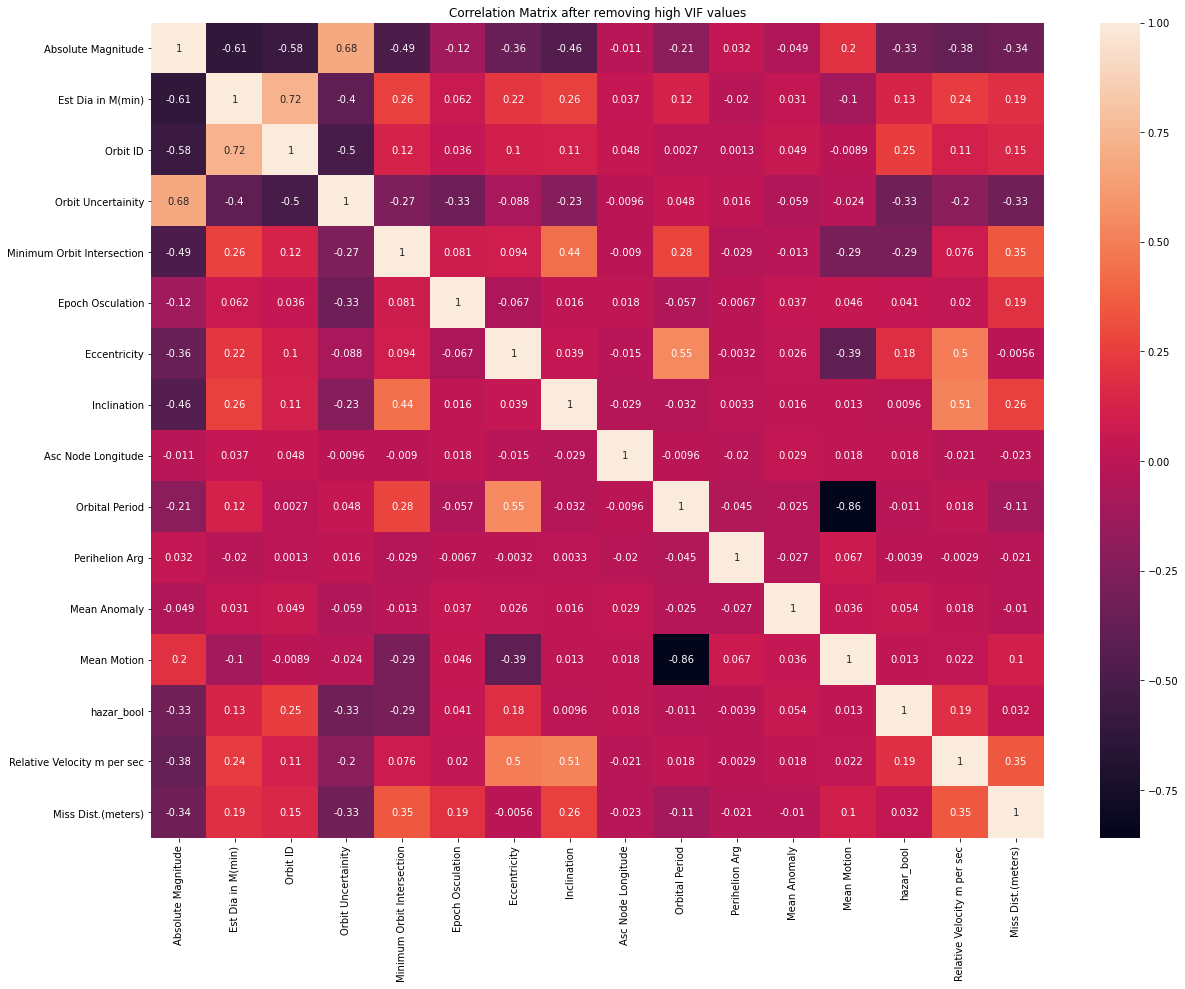

In [23]:
## Heatmap of Correlations after removing high VIF values:
plt.figure(figsize = (20,15))

sns.heatmap(after_vif.corr(),annot = True)
plt.title("Correlation Matrix after removing high VIF values")
plt.savefig("corrmatavif.png")

There is still presence of some multicollinearity. Next, we apply shrinkage method(Ridge Regression) for further selecting features. 

#### Apply Ridge Regression(Shrinkage method): 

Ridge Regression is a shrinkage method with values that have been 



#### Standarize data to change the variance to the same scale:

In [24]:
## BEFORE VIF:
object= StandardScaler()
columns_bvif = before_vif.columns
    
# standardization 
before_vif.loc[:, ~before_vif.columns.isin(['hazar_bool'])] = object.fit_transform(before_vif.loc[:, ~before_vif.columns.isin(['hazar_bool'])]) 
before_vif

## AFTER VIF:
object= StandardScaler()
columns_avif = after_vif.columns
    
# standardization 
after_vif.loc[:, ~after_vif.columns.isin(['hazar_bool'])] = object.fit_transform(after_vif.loc[:, ~after_vif.columns.isin(['hazar_bool'])]) 


In [25]:
after_vif.to_csv('after_vif_stand.csv', index=False)

##### Train Test Split

In [26]:
### X and Y for before VIF:
X_bvif = before_vif.loc[:, ~before_vif.columns.isin(['hazar_bool'])]
Y_bvif = before_vif['hazar_bool'] 

### X and Y for after VIF:
X_avif = after_vif.loc[:, ~after_vif.columns.isin(['hazar_bool'])]
Y_avif = after_vif['hazar_bool'] 

In [28]:
from imblearn.over_sampling import SMOTE
method = SMOTE(k_neighbors = 3)

X_resampled, y_resampled = method.fit_resample(X_avif,Y_avif)

In [29]:

def Ridge_Calculation(no_of_alphas, X, Y ):
    """
    Input: - Lambda values for the penalty term as input.
           - X values(design matrix values), Y(response values)
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=10)
    

    alphas = 10**np.linspace(10,-2,100)*0.5
    coefs = []
    pred = []
    mse = []
    
    #SELCTING OPTIMAL ALPHA VALUE}
    regr_cv = RidgeCV(alphas = alphas)
    model_cv = regr_cv.fit(X_train, y_train)
    optimal_alpha = model_cv.alpha_
    

    for a in alphas:
        ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
        ridge.fit(X_train, y_train)
        coefs.append(ridge.coef_)
        pred = ridge.predict(X_train) 
        mse.append(mean_squared_error(y_train, pred))

    columns = X.columns           
    return coefs, alphas, columns, mse, optimal_alpha




In [30]:
def plot_coefs(no_of_alphas, X, Y):
    
    coefs, alphas, columns, mse, optimal_alpha = Ridge_Calculation(no_of_alphas, X, Y )
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=10)
    
    regr_cv = RidgeCV(alphas = 150).fit(X_train, y_train)
    coefs_op = regr_cv.coef_ 
    
    plt.figure(figsize=(3,3))
    plt.bar(columns, coefs_op)
    plt.xticks(rotation='vertical')
    plt.title("Beta Coefficients at lambda = "+ str(optimal_alpha))
    plt.show()

    

In [31]:
def plot_ridge_trace(no_of_alphas, X, Y):
    """
    Plots beta_coefficients in Y axis
    Plots log_scaled alpha values in X axis
    Legend contains label of variables
    """
    
    coefs, alphas, columns, mse, op_alpha = Ridge_Calculation(no_of_alphas, X, Y )
    
    fig = plt.figure(figsize=(6.7,6.5))
    ax = plt.gca()
    ax.set_prop_cycle(cycler('color', ['b','g','r','c','m','y', 'k','tab:gray','lime','slateblue', 'maroon', 'cyan', 
                                       'sandybrown','crimson','lightpink','goldenrod','yellow','rosybrown','olive',
                                       'cadetblue', 'steelblue']))
    ax.plot(alphas, coefs)
    plt.axvline(x = op_alpha, linestyle='dotted')
    ax.set_xscale("log")
    ax.set_xlim(ax.get_xlim()[::1])  # reverse axis
    ax.set_xlabel("Lambda(log scale)")
    ax.set_ylabel("Beta Estimate")
    ax.set_title("Ridge Regression Trace", fontsize=16)
    plt.axis("tight")
    ax.legend(labels=columns, loc = 4)
    plt.grid()
    plt.show()
    

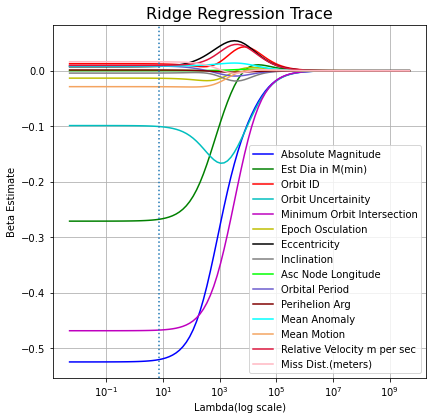

<Figure size 432x288 with 0 Axes>

In [34]:
#After Removing High VIF. variables
plot_ridge_trace(100, X_resampled, y_resampled)
plt.savefig("fig.png")

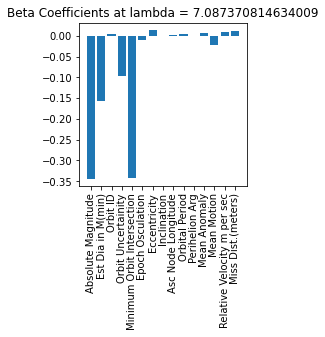

In [35]:
plot_coefs(100, X_resampled, y_resampled)


Looking at the ridge trace, some variables shrink faster than the others. We take a deeper look at the variables shrink slower.Variables like Minimum Orbit Intersection, Absolute Magnitude are expected to provide more information about hazar_bool. 

#### MSE:

In [36]:
def plot_mse_alpha(no_of_alphas, X, Y):
    """
    Plots MSE values in Y axis
    Plots log_scaled alpha values in X axis
    """
    
    coefs, alphas, columns, mse, optimal_alpha = Ridge_Calculation(no_of_alphas, X, Y )
    
    fig = plt.figure(figsize=(3,3))
    ax = plt.gca()
    ax.plot(alphas, mse)
    ax.set_xscale("log")
    ax.set_xlim(ax.get_xlim()[::1])  # reverse axis
    ax.set_xlabel("Lambda(log scale)")
    ax.set_ylabel("MSE")
    ax.set_title("MSE VS Alpha", fontsize=16)
    plt.axis("tight")
    plt.grid()
    plt.show()
  

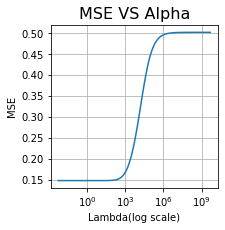

In [37]:
#After Removing High VIF variables
plot_mse_alpha(100, X_resampled, y_resampled)


In the MSE plot, it can be seen that as the value of alpha increases, the MSE values increases sharply. For building a predictive model using ridge regression, methods like 10-fold Cross validation can be done to find the optimal tuning parameter(alpha value). 

### Outliers:

Text(0.5, 1.0, 'Boxplot for viewing Outliers(Standardized Data)')

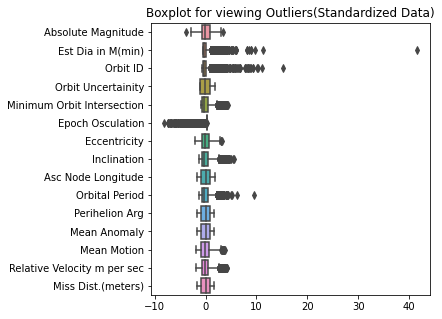

In [38]:
column = list(X_avif.columns)
plt.figure(figsize = (5,5))
sns.boxplot(data=after_vif[column], orient="h")
plt.title("Boxplot for viewing Outliers(Standardized Data)")

### Density of the variables from after_vif faceted by the Hazardous Nature:

The number of hazardous and non hazardous data points are disbalanced so a look at the density of the variables faceted by hazardous/non-hazardous nature to look for patterns might be helpful.

Should expect to see some noticeable patterns in variables like Minimum Orbit Intersection, Absolute Magnitude.

In [39]:
def plot_density_by_facet(dataframe, column, facet):
    """
    Input:
    ---------
    dataframe: Takes a dataframe as input
    column: Takes a list of character strings as input
    facet: Takes a character string as input
    """
    p9.options.figure_size = (3,3)

    for i in range(len(column)):
        gg = p9.ggplot(dataframe)
        gg+= p9.aes(x = column[i], fill = facet)
        gg+= p9.geom_density()
        gg+= p9.facet_wrap('~'+facet) 
        gg+= p9.labs (title = "Density of "+ str(column[i])+ " Faceted by:  "+ str(facet) + " ", x = str(column[i]), y = "Density") 
        gg+= p9.theme_bw()
        print(gg)

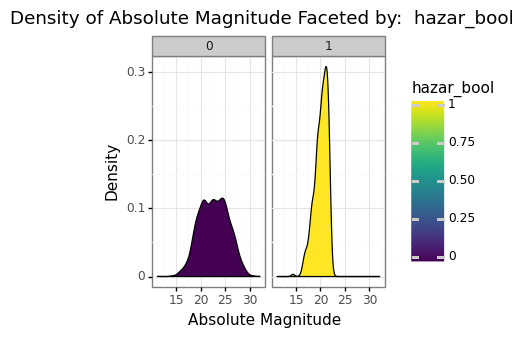

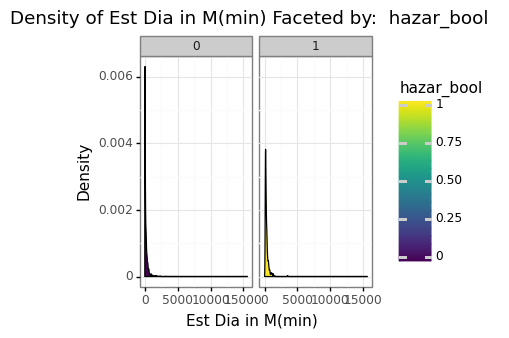

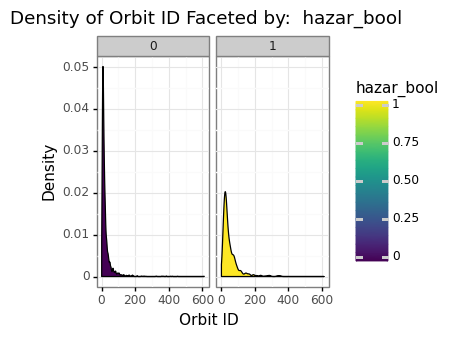

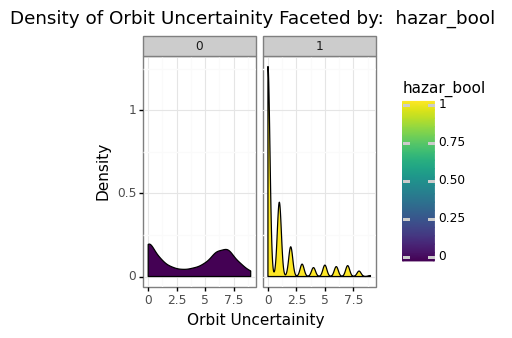

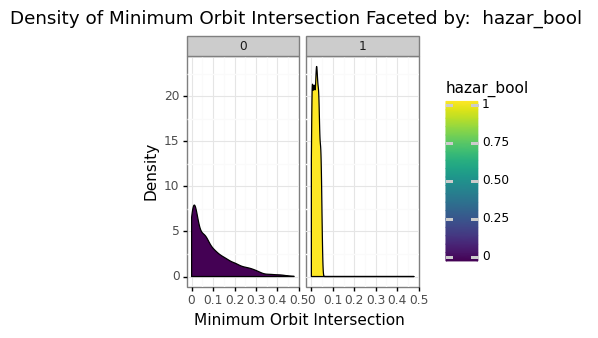

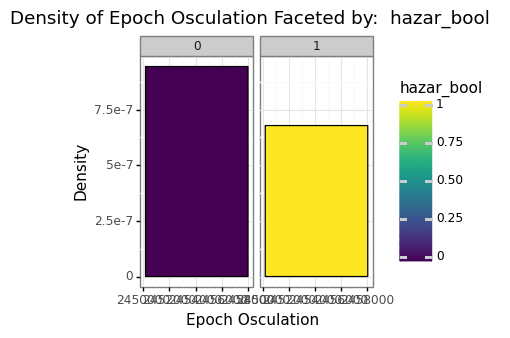

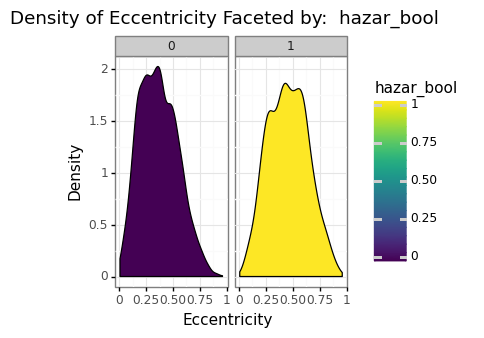

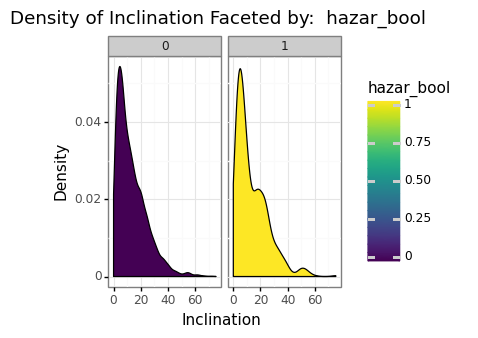

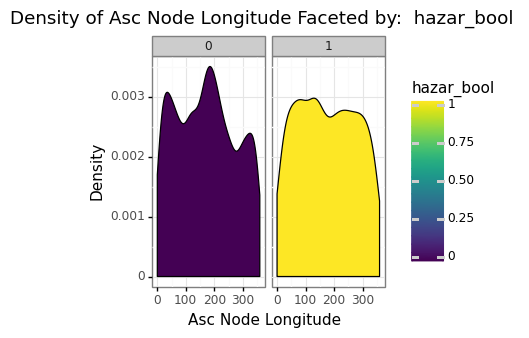

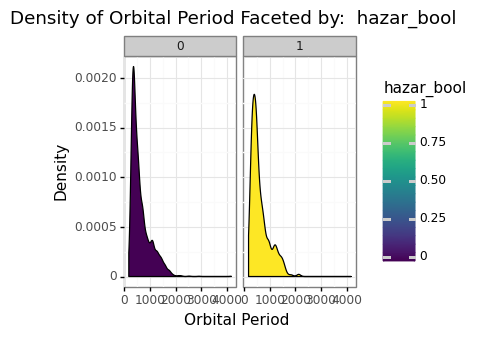

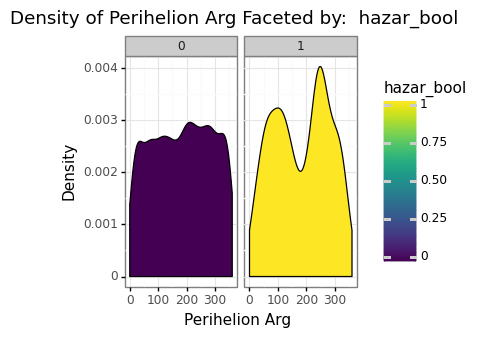

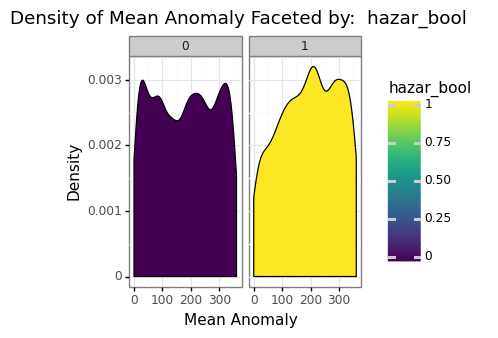

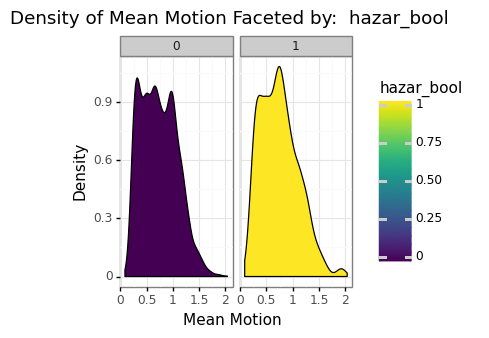

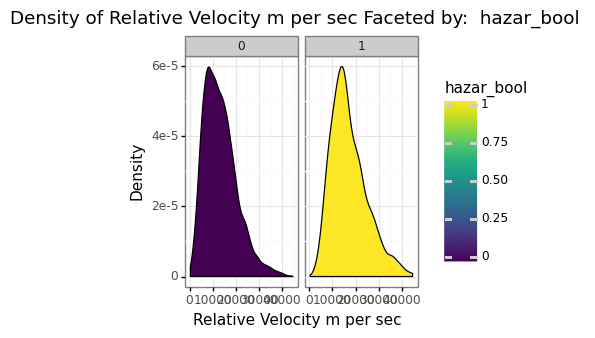

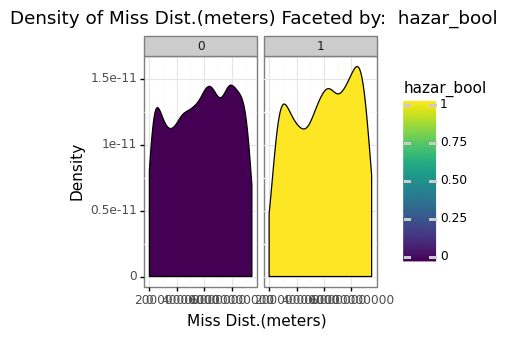

In [40]:
plot_density_by_facet(new, column, 'hazar_bool')

In [41]:
after_vif.columns

Index(['Absolute Magnitude', 'Est Dia in M(min)', 'Orbit ID',
       'Orbit Uncertainity', 'Minimum Orbit Intersection', 'Epoch Osculation',
       'Eccentricity', 'Inclination', 'Asc Node Longitude', 'Orbital Period',
       'Perihelion Arg', 'Mean Anomaly', 'Mean Motion', 'hazar_bool',
       'Relative Velocity m per sec', 'Miss Dist.(meters)'],
      dtype='object')

From the density plots, some variables have clear difference in pattern when faceted by hazardous and non-hazardous asteroids. 

Some variables that have clear pattern if the asteroid is hazardous: `Absolute Magnitude`, `Orbit Uncertainity`, `Minimum Orbit Intersection`


### Association of Variables: 

#### Changing some continuous values to categorical to look at contingency tables:

In [42]:
#Change the Minimum Orbit intersection distance to categorical:
data['Minimum Orbit Intersection'].describe()
after_vif['range_moid'] = pd.cut(data['Minimum Orbit Intersection'],bins=[0,0.005, 0.008, 0.009,0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.3,0.4])
after_vif['hazar_bool'] = new['hazar_bool']
pd.crosstab(index=new['hazar_bool'], columns=after_vif['range_moid'], normalize = 'index')


range_moid,"(0.0, 0.005]","(0.005, 0.008]","(0.008, 0.009]","(0.009, 0.01]","(0.01, 0.02]","(0.02, 0.03]","(0.03, 0.04]","(0.04, 0.05]","(0.05, 0.1]","(0.1, 0.2]","(0.2, 0.3]","(0.3, 0.4]"
hazar_bool,,,,,,,,,,,,
0,0.127567,0.043121,0.008214,0.007700,0.097279,0.062372,0.043891,0.034394,0.216632,0.220226,0.10806,0.030544
1,0.131126,0.063576,0.017219,0.009272,0.218543,0.231788,0.192053,0.136424,0.000000,0.000000,0.00000,0.000000


#### Minimum Orbit Intersection values below 0.05 are hazardous. The largest proportion of hazardous fall in the range between the values 0.01-0.05. 

In [43]:
#Absolute Magnitude:
data['Absolute Magnitude'].describe()
after_vif['range_abm'] = pd.cut(data['Absolute Magnitude'],bins=[0,5,10,15,18,19,20,21,22,23,25,30,35])
pd.crosstab(index=new['hazar_bool'], columns=after_vif['range_abm'],normalize = 'index')

range_abm,"(10, 15]","(15, 18]","(18, 19]","(19, 20]","(20, 21]","(21, 22]","(22, 23]","(23, 25]","(25, 30]","(30, 35]"
hazar_bool,,,,,,,,,,
0,0.001526,0.044252,0.068159,0.093337,0.118260,0.098678,0.116989,0.228128,0.2294,0.001272
1,0.002649,0.080795,0.117881,0.214570,0.286093,0.282119,0.015894,0.000000,0.0000,0.000000


In [44]:
#Orbit ID:
new['Orbit ID'].describe()
after_vif['range_obid'] = pd.cut(new['Orbit ID'],bins = [0,25,30, 50,100,200,300,400,500,600,700])
pd.crosstab(index=new['hazar_bool'], columns=after_vif['range_obid'], normalize = 'index')

range_obid,"(0, 25]","(25, 30]","(30, 50]","(50, 100]","(100, 200]","(200, 300]","(300, 400]","(400, 500]","(600, 700]"
hazar_bool,,,,,,,,,
0,0.751526,0.047304,0.102238,0.067396,0.026195,0.002543,0.001780,0.000763,0.000254
1,0.340397,0.108609,0.226490,0.229139,0.072848,0.017219,0.005298,0.000000,0.000000


##### Larger proportion of asteroids are hazardous with absolute magnitude between the range 15-25 

In [45]:
#Orbit Uncertainity:
new['Orbit Uncertainity'].describe()
after_vif['range_obun'] = pd.cut(new['Orbit Uncertainity'],bins = [0,0.25,0.5,1,2,4,6,8,10])
pd.crosstab(index=new['hazar_bool'], columns=after_vif['range_obun'], normalize = 'index')


range_obun,"(0.5, 1.0]","(1.0, 2.0]","(2.0, 4.0]","(4.0, 6.0]","(6.0, 8.0]","(8.0, 10.0]"
hazar_bool,,,,,,
0,0.139194,0.072927,0.116883,0.299034,0.331668,0.040293
1,0.453172,0.181269,0.129909,0.129909,0.099698,0.006042


#### Large proportion of hazardous have Orbit Certainty <0.5. Clear pattern, lower the orbit uncertainty, the larger the proportion of the asteroid are hazardous

In [46]:
#Asc Node Longitude:
new['Asc Node Longitude'].describe()
after_vif['range_ascnl'] = pd.cut(new['Asc Node Longitude'],bins=[0,50,100,150,200,250,300,350,400])
pd.crosstab(index=new['hazar_bool'], columns=after_vif['range_ascnl'], normalize = 'index')

range_ascnl,"(0, 50]","(50, 100]","(100, 150]","(150, 200]","(200, 250]","(250, 300]","(300, 350]","(350, 400]"
hazar_bool,,,,,,,,
0,0.163276,0.130214,0.137080,0.172940,0.140895,0.103764,0.124873,0.026958
1,0.136424,0.156291,0.144371,0.129801,0.140397,0.145695,0.123179,0.023841


##### Inconclusive

In [47]:
#Perihelion Arg:
new['Perihelion Arg'].describe()
after_vif['range_periarg'] = pd.cut(new['Perihelion Arg'],bins=[0,50,100,150,200,250,300,350,400])
pd.crosstab(index=new['hazar_bool'], columns=after_vif['range_periarg'], normalize = 'index')

range_periarg,"(0, 50]","(50, 100]","(100, 150]","(150, 200]","(200, 250]","(250, 300]","(300, 350]","(350, 400]"
hazar_bool,,,,,,,,
0,0.136317,0.126399,0.138606,0.133266,0.146999,0.146490,0.135554,0.036368
1,0.096689,0.161589,0.165563,0.088742,0.182781,0.169536,0.119205,0.015894


###### Inconclusive

In [48]:
#Relative Velocity:
new['Relative Velocity m per sec'].describe()
after_vif['range_rvmps'] = pd.cut(new['Relative Velocity m per sec'],bins=[0,5000,10000,15000,20000,25000,30000,35000,40000,45000])
con_rel = pd.crosstab(index=new['hazar_bool'], columns=after_vif['range_rvmps'], normalize = 'index')
con_rel

range_rvmps,"(0, 5000]","(5000, 10000]","(10000, 15000]","(15000, 20000]","(20000, 25000]","(25000, 30000]","(30000, 35000]","(35000, 40000]","(40000, 45000]"
hazar_bool,,,,,,,,,
0,0.085707,0.285097,0.270855,0.199135,0.093337,0.039929,0.016277,0.008138,0.001526
1,0.013245,0.161589,0.280795,0.238411,0.145695,0.088742,0.035762,0.027815,0.007947


##### Larger the relative velocity, larger the proportion of asteroids that are hazardous

In [49]:
#Est Dia in M(min) :
new['Est Dia in M(min)'].describe()
after_vif['range_dia'] = pd.cut(new['Est Dia in M(min)'],bins=[0,50,150,200,250,300,350,400,500,600,800,1000,1200,1400,16000])
pd.crosstab(index=new['hazar_bool'], columns=after_vif['range_dia'], normalize = 'index')

range_dia,"(0, 50]","(50, 150]","(150, 200]","(200, 250]","(250, 300]","(300, 350]","(350, 400]","(400, 500]","(500, 600]","(600, 800]","(800, 1000]","(1000, 1200]","(1200, 1400]","(1400, 16000]"
hazar_bool,,,,,,,,,,,,,,
0,0.39293,0.260936,0.071465,0.058240,0.038149,0.028993,0.027721,0.041709,0.021109,0.023906,0.013225,0.006612,0.004069,0.010936
1,0.00000,0.234437,0.178808,0.145695,0.091391,0.063576,0.060927,0.071523,0.049007,0.047682,0.022517,0.018543,0.010596,0.005298


#### larger the estimated diameter, larger the proportion of hazardous asteroids than non-hazardous asteroids

In [50]:
#Perihelion Distance:
new['Perihelion Distance'].describe()
after_vif['range_perdist'] = pd.cut(new['Perihelion Distance'],bins=[0,0.2,0.4,0.6,0.8,1.0,1.2])
pd.crosstab(index=new['hazar_bool'], columns=after_vif['range_perdist'], normalize = 'index')

range_perdist,"(0.0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]","(1.0, 1.2]"
hazar_bool,,,,,,
0,0.003763,0.038978,0.154839,0.249462,0.310484,0.242473
1,0.015894,0.074172,0.259603,0.268874,0.332450,0.049007


#### lower Perihelion distance may be hazardous

In [51]:
#Mean Motion:
new['Mean Motion'].describe()
after_vif['range_mmotion'] = pd.cut(new['Mean Motion'],bins=[0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2])
pd.crosstab(index=new['hazar_bool'], columns=after_vif['range_mmotion'], normalize = 'index')


range_mmotion,"(0.0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]","(1.0, 1.2]","(1.2, 1.4]","(1.4, 1.6]","(1.6, 1.8]","(1.8, 2.0]","(2.0, 2.2]"
hazar_bool,,,,,,,,,,,
0,0.007121,0.199644,0.183113,0.192269,0.178281,0.144710,0.062055,0.025941,0.005341,0.001272,0.000254
1,0.006623,0.196026,0.176159,0.221192,0.164238,0.117881,0.072848,0.027815,0.007947,0.009272,0.000000


#### Inconclusive distinction between hazardous, non-hazardous

In [52]:
#Inclination:
new['Inclination'].describe()
after_vif['range_inclin'] = pd.cut(new['Inclination'],bins=[0,5,10,15,20,25,35,45,65,75,85])
pd.crosstab(index=new['hazar_bool'], columns=after_vif['range_inclin'], normalize = 'index')

range_inclin,"(0, 5]","(5, 10]","(10, 15]","(15, 20]","(20, 25]","(25, 35]","(35, 45]","(45, 65]","(65, 75]","(75, 85]"
hazar_bool,,,,,,,,,,
0,0.250000,0.231689,0.166836,0.116989,0.096897,0.090285,0.032299,0.014242,0.000763,0.000000
1,0.262252,0.258278,0.101987,0.117881,0.107285,0.101987,0.026490,0.022517,0.000000,0.001325


##### Inconclusive

In [53]:
#Eccentricity:
new['Eccentricity'].describe()
after_vif['range_eccen'] = pd.cut(new['Eccentricity'],bins=[0,0.2,0.4,0.6,0.8,1.0])
pd.crosstab(index=new['hazar_bool'], columns=after_vif['range_eccen'], normalize = 'index')

range_eccen,"(0.0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]"
hazar_bool,,,,,
0,0.198627,0.390895,0.305188,0.096897,0.008393
1,0.082119,0.298013,0.381457,0.203974,0.034437


##### Larger Eccentricity >0.4, more hazardous


In [54]:
#Mean Anomaly:
new['Mean Anomaly'].describe()
after_vif['range_manomal'] = pd.cut(new['Mean Anomaly'],bins=[0,50,100,150,200,250,300,350,400])
pd.crosstab(index=new['hazar_bool'], columns=after_vif['range_manomal'], normalize = 'index')

range_manomal,"(0, 50]","(50, 100]","(100, 150]","(150, 200]","(200, 250]","(250, 300]","(300, 350]","(350, 400]"
hazar_bool,,,,,,,,
0,0.165565,0.139369,0.121567,0.121058,0.142930,0.128433,0.151068,0.03001
1,0.107285,0.108609,0.145695,0.129801,0.166887,0.147020,0.153642,0.04106


#### Inconclusive information from Mean Anomaly